# AssuredAllies home assignment
# Miri Michaelli

In [392]:
import pandas as pd
import os
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')


### data manipulation

In [284]:
# read files:
path_to_files = "/Users/mirimichaeli/projects/AssuredAllies/"
members = pd.read_excel(os.path.join(path_to_files, "members.xlsx"), sheet_name="members_data") # 1000 members
claims = pd.read_excel(os.path.join(path_to_files, "claims.xlsx"), sheet_name="claims_data") # 242 unique (no members with several claims)
reachouts = pd.read_excel(os.path.join(path_to_files, "reachouts.xlsx"), sheet_name="reachouts_data") # can be several reachouts per user, 662 unique ids

In [ ]:
# Program launch date - 2045-10-07
launch_date = pd.Timestamp('2045-10-07')

In [287]:
# add a flag to note if a claim/ reachout was made before of after the launch:
claims['claim_after_program_launch'] = claims['claim_initial_inquiry_date'] >= pd.Timestamp('2045-10-07') 
reachouts['reachout_after_program_launch'] = reachouts['reachout_date'] >= pd.Timestamp('2045-10-07')


In [288]:
# print(
#     len(set(reachouts.internal_id)),
#     len(set(intervention_group.internal_id)),
#     len(set(reachouts.internal_id) - set(intervention_group.internal_id)), # reachouts have 199 ids not from intervention group
#     len(set(reachouts.internal_id) - set(control_group.internal_id)) # the other reachouts are not from the control group
# )
# 662 500 199 662


In [289]:
intervention_group = members[members['group'] == 'intervention'] # 500
control_group = members[members['group'] == 'control'] # 500
# intervention_group.head()

In [290]:
# divide the members into groups of those with intervention before program launch and after program launch.
intervention_with_reachouts = intervention_group.merge(reachouts, on='internal_id', how='left')
intervention_before_launch = intervention_with_reachouts[intervention_with_reachouts['reachout_after_program_launch'] == False] # 323 for 221 members
intervention_after_launch = intervention_with_reachouts[intervention_with_reachouts['reachout_after_program_launch'] == True] # 2334 for 450 members


In [291]:
# groups are: 242 members with reachouts only after launch, 13 members with reachouts only before launch, 
# 208 members are in the intersection- have reachouts both before and after launch, I decided not to use these cases here.
# total: 463 members with reachouts out of the 500 members in the intervention group

members_with_reachouts_only_after_launch = list(set(intervention_after_launch['internal_id']) - set(intervention_before_launch['internal_id'])) # 242
members_with_reachouts_only_before_launch = list(set(intervention_before_launch['internal_id']) - set(intervention_after_launch['internal_id'])) # 13

# filter the df by the specific members in each group from the lists above:
intervention_only_after_launch = intervention_after_launch.loc[intervention_after_launch['internal_id'].isin(
    members_with_reachouts_only_after_launch)]
intervention_only_before_launch = intervention_before_launch.loc[intervention_before_launch['internal_id'].isin(
    members_with_reachouts_only_before_launch)]


In [ ]:
# due to the low number of members with interventions only before the launch, I will include members from the intersection group, but only members that 
# the new intervention (after the launch date), is more than 3 months after the last "old" intervention: (215 members: 13+202)
combined_reachouts = reachouts[reachouts['reachout_after_program_launch'] == False].merge(
    reachouts[reachouts['reachout_after_program_launch'] == True], on='internal_id', how='outer')
combined_reachouts = combined_reachouts[combined_reachouts['reachout_after_program_launch_x'].notna() & 
                                         combined_reachouts['reachout_after_program_launch_y'].notna()]
combined_reachouts['more_than_3_months_between_intervention_types'] = \
    combined_reachouts['reachout_date_y'] > combined_reachouts['reachout_date_x'] + pd.DateOffset(months=3)
members_with_both_but_ok_to_include_in_before_group = combined_reachouts[combined_reachouts['more_than_3_months_between_intervention_types'] == True]['internal_id'].unique() # 202 members
members_with_reachouts_before_launch = list(set(members_with_reachouts_only_before_launch).union(set(members_with_both_but_ok_to_include_in_before_group)))

intervention_before_launch = intervention_with_reachouts.loc[intervention_with_reachouts['internal_id'].isin(members_with_reachouts_before_launch)]


In [292]:
# take only 3 months range after the launch date for the after launch group:
three_months_after_launch = launch_date + relativedelta(months=+3)
intervention_3_months_after_launch = intervention_only_after_launch[intervention_only_after_launch['reachout_date'] <= three_months_after_launch] 
# len(intervention_3_months_after_launch.internal_id.unique())

In [ ]:
## merge each of the 2 df with claims to calculate claim rate:

# for before-launch group:
# check how many claims in the 3-months range after an intervention:
claims_of_3_months_before_launch = intervention_before_launch.merge(claims, on='ph_id', how='left', suffixes=[None,'_claims'])
before_launch_claims = claims_of_3_months_before_launch[claims_of_3_months_before_launch['claim_start_date'] <= 
                                                        pd.to_datetime(claims_of_3_months_before_launch['reachout_date']) + pd.DateOffset(months=3)] 
number_of_before_claims = len(before_launch_claims) # 101 claims


# for after-launch:
# filter claims issued only after a first reachout has been made to member, otherwise, it's irrelevant:
first_intervention_3_months_after_launch = intervention_3_months_after_launch.sort_values('reachout_date').groupby('internal_id').first()
first_intervention_3_months_after_launch.reset_index(inplace=True)
claims_of_3_months_after_launch = first_intervention_3_months_after_launch.merge(claims, on='ph_id', how='left', suffixes=[None,'_claims'])
after_launch_claims = claims_of_3_months_after_launch[claims_of_3_months_after_launch['reachout_date'] <= 
                                                      claims_of_3_months_after_launch['claim_start_date']] # 33 claims, might contain claims more than 3 months after reachouts

# another option is to take only claims that are in the range of 3 months after one of the reachouts to a member:
claims_of_3_months_after_launch = intervention_3_months_after_launch.merge(claims, on='ph_id', how='left',suffixes=[None,'_claims'])
after_launch_claims_max_3_months = claims_of_3_months_after_launch[(claims_of_3_months_after_launch['reachout_date'] <= 
                                                                    claims_of_3_months_after_launch['claim_start_date']) &
                                      (claims_of_3_months_after_launch['claim_start_date'] <= 
                                       pd.to_datetime(claims_of_3_months_after_launch['reachout_date']) + pd.DateOffset(months=3))] # 12


number_of_after_claims = len(after_launch_claims) 
number_of_after_claims_max_3_months = len(after_launch_claims_max_3_months.internal_id.unique())


### calculate claim rates (Claim incidence rate: number of claims, normalized by group size and measurement duration):


In [476]:
the_before_period =  max(before_launch_claims['claim_start_date']) - min(before_launch_claims['claim_start_date']) # 770
the_after_period = max(after_launch_claims_max_3_months['claim_start_date']) - min(after_launch_claims_max_3_months['claim_start_date']) # 137
# claim incidence rate normalized by number of members in the groups and by days in the periods:
claim_incidence_rate_before_launch = number_of_before_claims*365/(len(members_with_reachouts_only_before_launch)*the_before_period.days)
claim_incidence_rate_after_launch = number_of_after_claims_max_3_months*365/(len(intervention_3_months_after_launch['internal_id'].unique())*the_after_period.days)

In [477]:
print(
    'claim inceidence rate before launch:',
    claim_incidence_rate_before_launch,
    f'in {the_before_period.days} days.'
    '\nclaim inceidence rate after launch:',
    claim_incidence_rate_after_launch,
    f'in {the_after_period.days} days.'

    )

claim inceidence rate before launch: 0.6046416270296867 in 4690 days.
claim inceidence rate after launch: 0.1321107558665621 in 137 days.


### distribution of claims per month from first reachout:


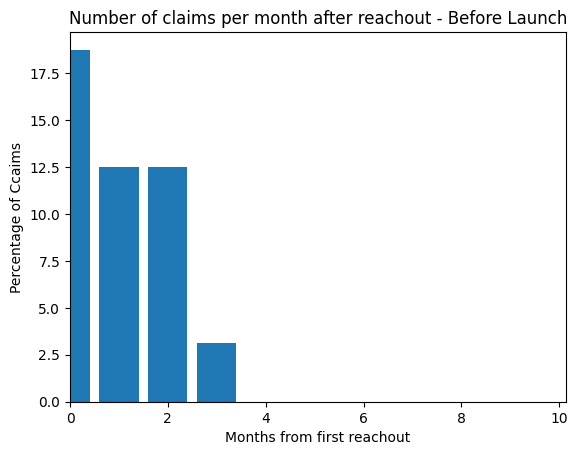

In [493]:

## for before launch:
before_launch_claims.dropna(subset=['claim_start_date'], inplace=True)
before_launch_claims['reachout_date'] = pd.to_datetime(before_launch_claims['reachout_date'])
before_launch_claims['claim_start_date'] = pd.to_datetime(before_launch_claims['claim_start_date'])
before_launch_claims['time_difference'] = (before_launch_claims['claim_start_date'] - before_launch_claims.groupby('internal_id')['reachout_date'].transform('min')).dt.days // 30
# remove duplicates to get unique member IDs
unique_ids = before_launch_claims.drop_duplicates(subset='internal_id')

# calculate the total number of claims to preent the graph as percentages
total_claims = unique_ids['internal_id'].count()

# group the data by time difference and count the number of unique member IDs
results = (unique_ids.groupby('time_difference')['internal_id'].count() / total_claims) * 100

# create the bar plot
plt.bar(results.index, results.values)
plt.xlabel('Months from first reachout')
plt.ylabel('Percentage of Ccaims')
plt.title('Number of claims per month after reachout - Before Launch')
plt.xlim(left=0) # there are claims which were made before any intervention..
plt.show()

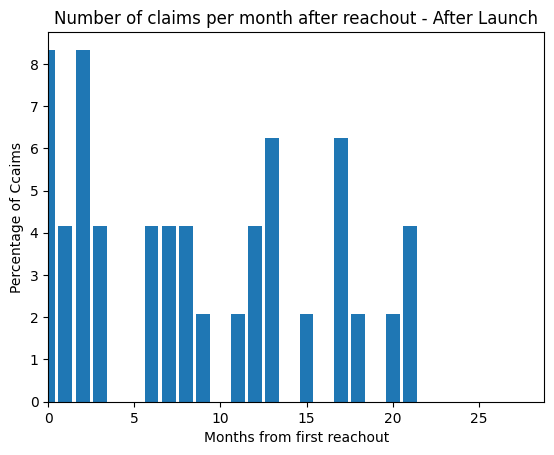

In [482]:

## for after launch:
claims_of_3_months_after_launch.dropna(subset=['claim_start_date'], inplace=True)
claims_of_3_months_after_launch['reachout_date'] = pd.to_datetime(claims_of_3_months_after_launch['reachout_date'])
claims_of_3_months_after_launch['claim_start_date'] = pd.to_datetime(claims_of_3_months_after_launch['claim_start_date'])
claims_of_3_months_after_launch['time_difference'] = (claims_of_3_months_after_launch['claim_start_date'] - claims_of_3_months_after_launch.groupby('internal_id')['reachout_date'].transform('min')).dt.days // 30

# remove duplicates to get unique member IDs
unique_ids = claims_of_3_months_after_launch.drop_duplicates(subset='internal_id')

# calculate the total number of claims to preent the graph as percentages
total_claims = unique_ids['internal_id'].count()

# group the data by time difference and count the number of unique member IDs
results = (unique_ids.groupby('time_difference')['internal_id'].count() / total_claims) * 100


# create the bar plot
plt.bar(results.index, results.values)
plt.xlabel('Months from first reachout')
plt.ylabel('Percentage of Ccaims')
plt.title('Number of claims per month after reachout - After Launch')
plt.xlim(left=0) # there are claims which were made before any intervention..
plt.show()



### statistical test to show whether the two groups differ:

In [431]:
# binary table of all states per member
members['is_intervention'] = np.where(members['group']== 'intervention', 1, 0)
members['treatment_group'] = np.where(members['internal_id'].isin(members_with_reachouts_only_after_launch), 1, 0) # True if after launch
members['has_claim'] = np.where(members['ph_id'].isin(claims['ph_id']), 1, 0)
data_for_test = members[['is_intervention','treatment_group','has_claim']]
data_for_test

,is_intervention,treatment_group,has_claim
0,1,0,0
1,1,0,0
2,1,1,0
3,1,0,0
4,1,1,1
...,...,...,...
995,0,0,0
996,0,0,0
997,0,0,0
998,0,0,0


### check significance of the rate difference by CI

In [488]:

# the standard deviation for each group
std_dev_group1 = np.sqrt(claim_incidence_rate_before_launch * (1 - claim_incidence_rate_before_launch))
std_dev_group2 = np.sqrt(claim_incidence_rate_after_launch * (1 - claim_incidence_rate_after_launch))

# the standard error for each group
std_error_group1 = std_dev_group1 / np.sqrt(len(members_with_reachouts_only_before_launch))
std_error_group2 = std_dev_group2 / np.sqrt(len(intervention_3_months_after_launch['internal_id'].unique()))

# set the desired level of confidence
confidence_level = 0.95

# the critical value from the standard normal distribution
critical_value = stats.norm.ppf((1 + confidence_level) / 2)

# the margin of error
margin_of_error = critical_value * np.sqrt(std_error_group1**2 + std_error_group2**2)

# the confidence interval
difference_rates = claim_incidence_rate_before_launch - claim_incidence_rate_after_launch
lower_bound = difference_rates - margin_of_error
upper_bound = difference_rates + margin_of_error

print(f'Confidence Interval: {lower_bound}, {upper_bound}')


Confidence Interval: [-0.6100, -0.3505]


-0.48027164258639854

### visualization:

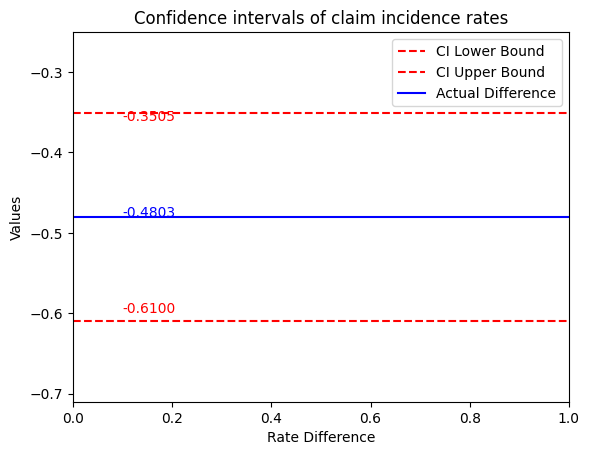

In [492]:

plt.axhline(y=lower_bound, color='red', linestyle='--', label='CI Lower Bound')
plt.axhline(y=upper_bound, color='red', linestyle='--', label='CI Upper Bound')

# plot the actual rate difference
plt.axhline(y=difference_rates, color='blue', linestyle='-', label='Actual Difference')

# y-axis limits
plt.ylim(lower_bound - 0.1, upper_bound + 0.1)

# labels and legend
plt.xlabel('Rate Difference')
plt.ylabel('Values')
plt.legend()

# text annotations for the values
plt.text(0.1, lower_bound + 0.01, f'{lower_bound:.4f}', color='red')
plt.text(0.1, upper_bound - 0.01, f'{upper_bound:.4f}', color='red')
plt.text(0.1, difference_rates, f'{difference_rates:.4f}', color='blue')
plt.title('Confidence intervals of claim incidence rates')

plt.show()

### calculate the claim rates for control groups:

In [485]:
# 1. all control members as in: control_group
# 2. claims before launch_date
# 3. claims after launch_date (and for 3 months)

claims_control_group = control_group.merge(claims, on='ph_id', how='left', suffixes=[None,'_claims'])
claims_control_group_before = claims_control_group[claims_control_group['claim_start_date'] <= launch_date]
claims_control_group_after = claims_control_group[claims_control_group['claim_start_date'] > launch_date]

number_of_control_claims = sum(claims_control_group['claim_start_date'].notna()) # 89
number_of_control_claims_before_launch = len(claims_control_group_before) # 23
number_of_control_claims_after_launch = len(claims_control_group_after) # 66
number_of_control_claims_3_months_after_launch = len(claims_control_group[(claims_control_group['claim_start_date'] > launch_date) &
                                                                          (claims_control_group['claim_start_date'] <= three_months)]) # 6

# calculate claim rates (Claim incidence rate: number of claims, normalized by group size and measurement duration):

the_before_period =  max(claims_control_group_before['claim_start_date']) - min(claims_control_group_before['claim_start_date']) # 7993 days
the_after_period = max(claims_control_group_after['claim_start_date']) - min(claims_control_group_after['claim_start_date']) # 694 days
# claim incidence rate normalized by number of members in the groups and by days in the periods:
claim_incidence_rate_before_launch = number_of_control_claims_before_launch*365/(len(claims_control_group_before['internal_id'].unique())*the_before_period.days)
claim_incidence_rate_after_launch = number_of_control_claims_after_launch*365/(len(claims_control_group_after['internal_id'].unique())*the_after_period.days)

claim_rate_throughout = number_of_control_claims*365/(len(claims_control_group['internal_id'].unique())* \
                                                      (max(claims_control_group['claim_start_date']) - min(claims_control_group['claim_start_date'])).days)


In [486]:
print(
    'Controls:\n'
    'claim inceidence rate before launch:',
    claim_incidence_rate_before_launch,
    f'in {the_before_period.days} days.'
    '\nclaim inceidence rate after launch:',
    claim_incidence_rate_after_launch,
    f'in {the_after_period.days} days.',
    '\nclaim incidence rate throughout the program:',
    claim_rate_throughout
    )

Controls:
claim inceidence rate before launch: 0.04566495683723258 in 7993 days.
claim inceidence rate after launch: 0.5259365994236311 in 694 days. 
claim incidence rate throughout the program: 0.007444711813910852
